# Chater 6. 복잡한 시계열 모델링하기

자귀회기이동평균과정은 자귀회귀과정과 이동평균과정의 조합

ARMA(p, q)로 표시하며, 여기서 $p$는 자귀회귀과정의 차수이고, $q$는 이동평균과정의 차수. ARMA($p, q$)과정의 일반적 수식은

$$ y_i = C + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \phi_p y_{t-p} + \cdots \ + \mu + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \cdots \theta_q \epsilon_{t-q}$$

- `statsmodels` 라이브러리에서는 자기회귀과정의 계수 부호를 반대로 입력해야한다

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from itertools import product
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings('ignore')


In [2]:
np.random.seed(42)

In [5]:
ar1 = np.array([1, -0.33])
ma1 = np.array([1, 0.9])

ARMA_1_1 = ArmaProcess(ar1, ma1).generate_sample(nsample = 1000)

In [8]:
ADF_result = adfuller(ARMA_1_1)
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -7.495856326650709
p-value: 4.381753798932391e-11


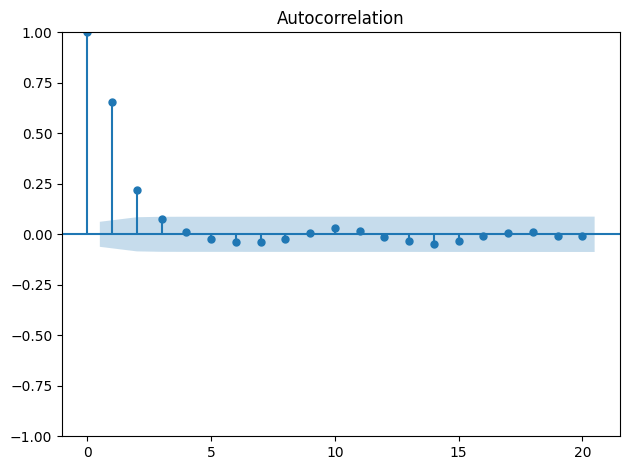

In [13]:
plot_acf(ARMA_1_1, lags = 20)
plt.tight_layout()

위 그림에서 사인 곡선 패턴을 볼 수 있음 -> AR이 있음을 암시

MA(1) 프로세스이므로 lag 1 까지만 유의하여야 함 

ACF 그래프는 ARMA(1,1) 프로세스의 차수 $q$에 대한 유용한 정보를 제공하지 않음

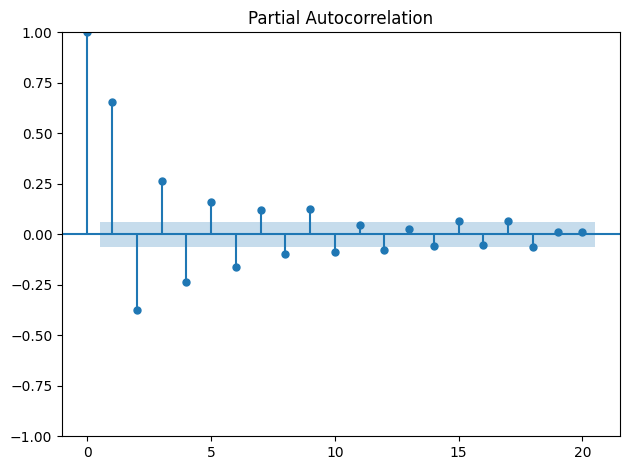

In [14]:
plot_pacf(ARMA_1_1, lags=20)
plt.tight_layout()

명확한게 사인곡선의 형태. 차수 $p$ 값을 유추할 수 없음

## 6.4 일반적 모델링 절차 고안하기

ACF, PACF 모두 사인곡선이나 감쇄 패턴을 보이는 경우, 해당 시계열은 ARMA($p, q$) 프로세스

### 6.4.1 아카이케 정보 기준 이해하기

AIC는 모델의 품질을 다른 모델들과 비교하여 상대적으로 정량화

$$ AIC = 2k - 2ln(\hat{L}) $$

k: 매개변수의 개수, L: maximum likelihood

우도함수(가능도 함수)는 모델이 피팅하기에 적합한지(goodness of fit)을 측정. 관측된 데이터 집합에서 모델의 여러가지 매개변수가 관측된 데이터를 생성할 가능성을 추정

확률 분포 함수는 매개변수가 정해진 모델에서 데이터 요소가 관측될 확률을 측정

AIC를 이용하면 모델의 매개변수의 개수와 훈련 데이터에 대한 적합도 사이에서 균형을 잡을 수 있다


### 6.4.2 AIC를 사용하여 모델 선택하기

In [16]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)

order_list = list(product(ps, qs))

In [56]:
def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:
        
    results = []
    
    for order in order_list:
        try:
            model = SARIMAX(endog, order = (order[0], 0, order[1]), sample_dfferencing=False).fit(disp=False)
            
        except:
            continue
        
        aic = model.aic         
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    result_df = result_df.sort_values(by="AIC", ascending=True).reset_index(drop=True)
    
    return result_df

In [57]:
result_df = optimize_ARMA(ARMA_1_1, order_list)
result_df
            

,"(p,q)",AIC
0,"(1, 1)",2841.895212
1,"(1, 2)",2843.511266
2,"(2, 1)",2843.562692
3,"(3, 1)",2845.058661
4,"(1, 3)",2845.313001
5,"(2, 2)",2845.802404
6,"(3, 3)",2846.022542
7,"(0, 3)",2846.608267
8,"(2, 3)",2847.497879
9,"(3, 2)",2847.561710
